In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
from scipy.stats import norm 


In [50]:
from datetime import datetime, time
import pandas_datareader.data as pdr
#import yfinance as yf

In [51]:
import yfinance as yf

In [101]:
%run -i volatility.py

<Figure size 640x480 with 0 Axes>

In [54]:
import math

In [53]:
def black_scholes(s0, k, r, t, sigma, y, option_type):
    T = t/252  #daily to yearly 
    s = s0 * np.exp(-y*T)
    
    d1 = (np.log(s0/k) + (((r-y) + (sigma**2)/2)*T))/ (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
  
   
   #calculating option price and implied volatility
    if option_type == 'Call':
        value = s*norm.cdf(d1,0,1)- k * np.exp(-r*T) * norm.cdf(d2,0,1) 
        1
           

    else:
       
        value =  (k * np.exp(-r *T)* norm.cdf(-d2,0,1)) - (s* norm.cdf(-d1,0,1))
        #
        
        
    
    # calculating break even point
    if option_type == 'Call': 
        bep = k + value
    else:
        bep = k - value
        
    #delta
    if y >0.0 and T > 0.0:
        yfac = np.exp(-y*T)
    else:
        yfac = 1.0
    
    if option_type == 'Call' : delta = yfac * norm.cdf(d1) 
    else:  delta = yfac* (norm.cdf(d1) -1)
    
    #gamma
    gamma = (yfac * norm.pdf(d1)) /(s0 * sigma * np.sqrt(T))
    
    #theta
    if option_type =='Call':
        theta = (-((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T)) + r * k *np.exp(-r*T)*norm.cdf(d2) - y*s*norm.cdf(d1)))/252
    else:
        theta = (-((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T)) - r * k* np.exp(-r*T)*norm.cdf(d2,0,1) +  y*s*norm.cdf(-d1)))/252
    
    #vega
    vega = (s* np.sqrt(T) * norm.pdf(d1))/100
    
    #rho
    if option_type == 'Call':
        rho =( k * T * np.exp(-r*T)*norm.cdf(d2))/100
    else:
        rho = (-(k * T * np.exp(-r*T)*norm.cdf(-d2,0,1)))/100

    #implied volatility # , "implied volatility  " :im_vol.round(4)

    option_values = {
        "option_type" : option_type,
        "premium" : value.round(4), "Breakeven point": bep.round(4),  "detla" :  delta.round(4), "gamma" : gamma.round(4), 
        "theta" : theta.round(4), "vega" : vega.round(4),'rho' :  rho.round(4)
}
    
    return option_values

In [7]:
def black_scholes_1(S, K, T,y, r, sigma, option='call'):
    d1 = (math.log(S / K) + ((r-y) + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = (math.log(S / K) + ((r-y) - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    
    if option == 'call':
        return S *norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    if option == 'put':
        return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [8]:
def BS(s,k,r,t,sigma,type='C'):
    T = t/252
    d1 =  (np.log(s/k) + ((r + sigma**2/2)*T))/ (sigma * np.sqrt(T))
    d2 =  d1 - (sigma * np.sqrt(T))
    try:
        if type == 'C':
            price = s*norm.cdf(d1,0,1) -k*np.exp(-r*T)*norm.cdf(d2,0,1)
        elif type == 'P':
            price = k * np.exp(-r * T) * norm.cdf(-d2,0,1) - s * norm.cdf(-d1,0,1)
    except:
        print("Please input correct parameters")
    
    return price

##### Ticker and expiry date

In [182]:
ticker = 'AMZN'
expiry_date = '10-18-2024'


In [183]:
today = datetime.now().date()
five_year_ago = today.replace(year = today.year-5)
one_year_ago = today.replace(year = today.year-1)

In [184]:
stock = yf.Ticker(ticker)
df = yf.download(ticker,start = five_year_ago, end = today,rounding = True)


[*********************100%%**********************]  1 of 1 completed


In [185]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-05,91.10,92.10,90.78,92.04,92.04,66216000
2019-09-06,91.91,92.03,91.32,91.68,91.68,49938000
2019-09-09,92.05,92.50,91.23,91.57,91.57,59990000
2019-09-10,91.14,91.29,90.27,91.03,91.03,52278000
2019-09-11,90.61,91.67,90.45,91.15,91.15,48656000


In [186]:
df_returns = pd.DataFrame()
df_returns['Close'] = df['Close']

In [187]:
df_returns.head()

,Close
Date,
2019-09-05,92.04
2019-09-06,91.68
2019-09-09,91.57
2019-09-10,91.03
2019-09-11,91.15


In [188]:
#calculating returns
df_returns['returns'] = df_returns['Close'].pct_change()

In [189]:
df_returns['cum_ret'] = (df_returns['returns'] +1).cumprod()


In [190]:
df_returns.dropna().head()

,Close,returns,cum_ret
Date,,,
2019-09-06,91.68,-0.003911,0.996089
2019-09-09,91.57,-0.001200,0.994894
2019-09-10,91.03,-0.005897,0.989027
2019-09-11,91.15,0.001318,0.990330
2019-09-12,92.18,0.011300,1.001521


In [191]:
log_returns = np.log(df_returns["Close"]/df_returns['Close'].shift(1))

In [192]:
df_returns['log_returns'] = log_returns
df_returns.head()

,Close,returns,cum_ret,log_returns
Date,,,,
2019-09-05,92.04,NaN,NaN,NaN
2019-09-06,91.68,-0.003911,0.996089,-0.003919
2019-09-09,91.57,-0.001200,0.994894,-0.001201
2019-09-10,91.03,-0.005897,0.989027,-0.005915
2019-09-11,91.15,0.001318,0.990330,0.001317


#### Plotting returns

<Axes: xlabel='Date', ylabel='Close'>

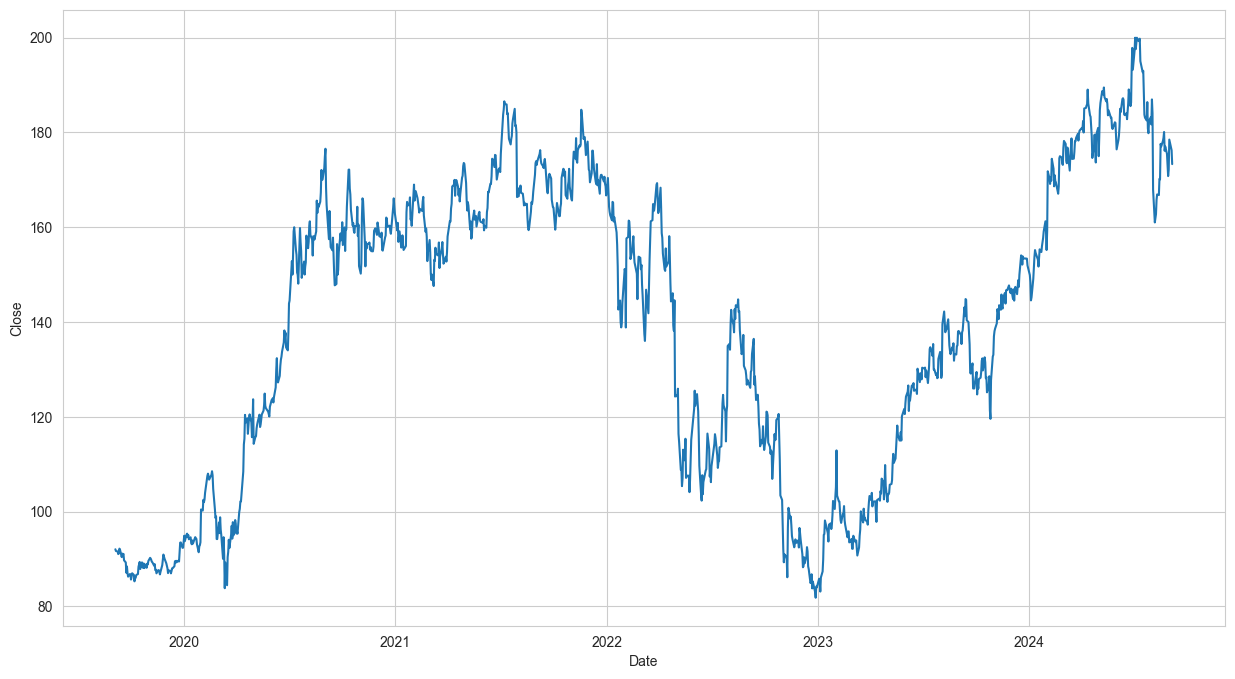

In [193]:
#Visualize the price
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['Close'] )

<Axes: xlabel='Date', ylabel='log_returns'>

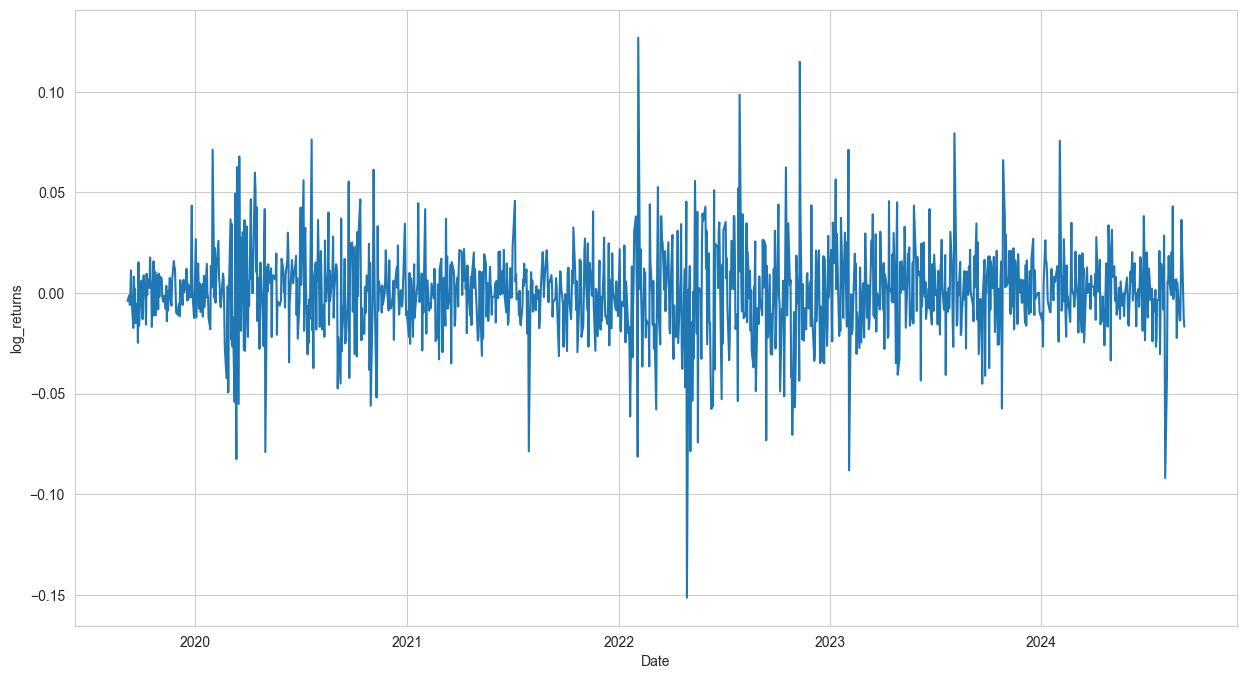

In [194]:
#Visualizing log return
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['log_returns'])

<Axes: xlabel='Date', ylabel='cum_ret'>

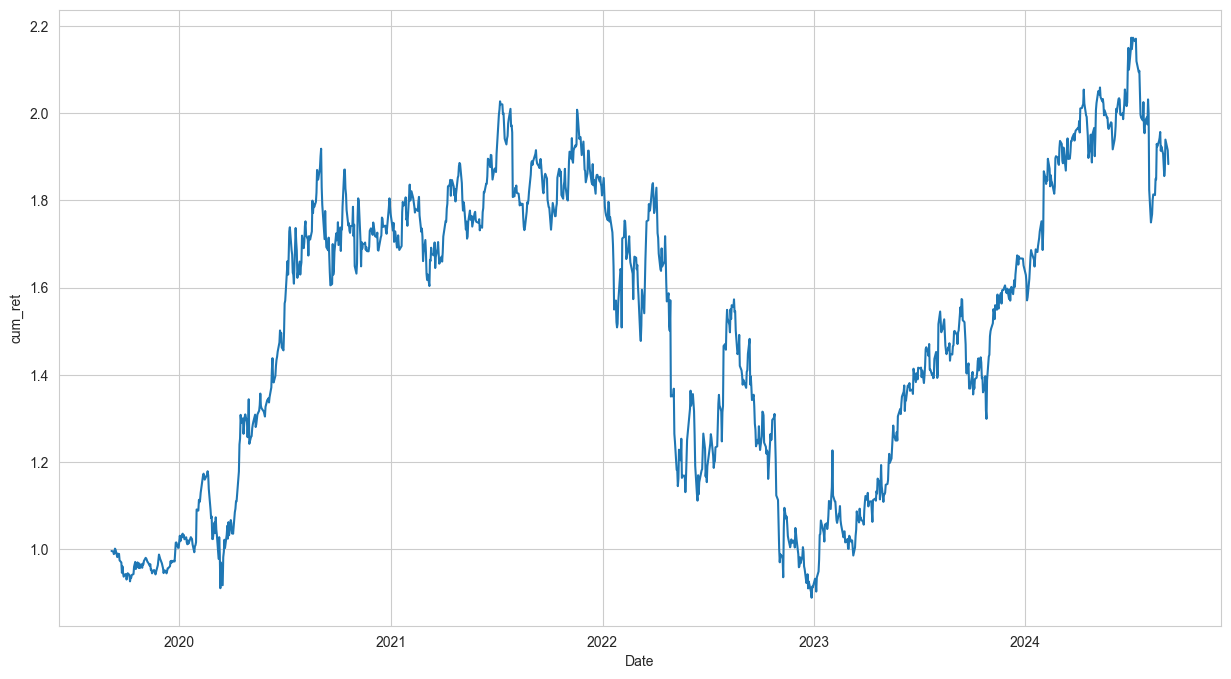

In [195]:
#Visualizing return
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['cum_ret'])

Annualised dividend

In [196]:
dividends = stock.history(start= one_year_ago, end = today)['Dividends']
#type(dividends)
annual_div = dividends.sum()
print(annual_div)

0.0


In [197]:
stock.info


{'address1': '410 Terry Avenue North',
 'city': 'Seattle',
 'state': 'WA',
 'zip': '98109-5210',
 'country': 'United States',
 'phone': '206 266 1000',
 'website': 'https://www.aboutamazon.com',
 'industry': 'Internet Retail',
 'industryKey': 'internet-retail',
 'industryDisp': 'Internet Retail',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': "Amazon.com, Inc. engages in the retail sale of consumer products, advertising, and subscriptions service through online and physical stores in North America and internationally. The company operates through three segments: North America, International, and Amazon Web Services (AWS). It also manufactures and sells electronic devices, including Kindle, Fire tablets, Fire TVs, Echo, Ring, Blink, and eero; and develops and produces media content. In addition, the company offers programs that enable sellers to sell their products in its stores; and programs that allow auth

In [199]:
#Dividend yield
if annual_div == 0.0:
    div_yield = 0.0 
    print(div_yield)
else:
    div_yield = stock.info['trailingAnnualDividendYield']
    print(div_yield)

0.0


##### Sigma 

In [200]:
#one year volatility
sigma = (df_returns['log_returns'].std())*np.sqrt(252)
print(sigma)

0.3545306717726878


In [201]:
sigma_1 = (df_returns['returns'].std())*np.sqrt(252)
print(sigma_1)

0.3545891181477352


In [202]:
def returns(window,trading_periods):
    result = log_returns.rolling(window,center=False).std()* np.sqrt(trading_periods)
    return result

In [203]:
def returns_normal(window,trading_periods):
    result = df_returns['returns'].rolling(window,center=False).std()* np.sqrt(trading_periods)
    return result

In [204]:
returns_normal(20,252)

Date
2019-09-05         NaN
2019-09-06         NaN
2019-09-09         NaN
2019-09-10         NaN
2019-09-11         NaN
                ...   
2024-08-28    0.417980
2024-08-29    0.417741
2024-08-30    0.300011
2024-09-03    0.258602
2024-09-04    0.269272
Name: returns, Length: 1258, dtype: float64

#### Risk-free rate

In [205]:
#risk-free rate, as the 6 month U.S. treasury yield which could get from ^TNX
r = 0.0538*100
print(r)

5.38


In [206]:
def get_10yr_treasury_rate():
    # 10 year treasury ticker symbol
    treasury_ticker = "^TNX"
    now = datetime.now()
    ten_years_ago = now.replace(year=now.year - 10)
    treasury_data = yf.download(treasury_ticker, start=ten_years_ago, end=now)
    last_yield = treasury_data['Close'].iloc[-1]
    return last_yield

In [219]:
last_yield = get_10yr_treasury_rate()/100
print(last_yield)

[*********************100%%**********************]  1 of 1 completed

0.03726999998092651


#### Current stock price

In [208]:
#current stock price
s = df_returns['Close'].iloc[-1]
print(s)

173.33


#### Time

In [209]:
# time remaining untill expiration in days
t = (datetime.strptime(expiry_date, "%m-%d-%Y") - datetime.utcnow()).days +1
t

43

In [221]:
vol = hodges_tompkins(df, t)[-1]
print(vol)

0.3612697520160249


/var/folders/dw/c3ntnt1x4kn59s38pldw62hr0000gn/T/ipykernel_17660/2366614791.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol = hodges_tompkins(df, t)[-1]


In [225]:
vol_std = std_dev(df,t)[-1]
print(vol_std)

0.34863482439534693


/var/folders/dw/c3ntnt1x4kn59s38pldw62hr0000gn/T/ipykernel_17660/362986878.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol_std = std_dev(df,t)[-1]


In [210]:
vol =[]
vol= returns(t,252).to_list()
print(vol[-1])

0.34863482439534693


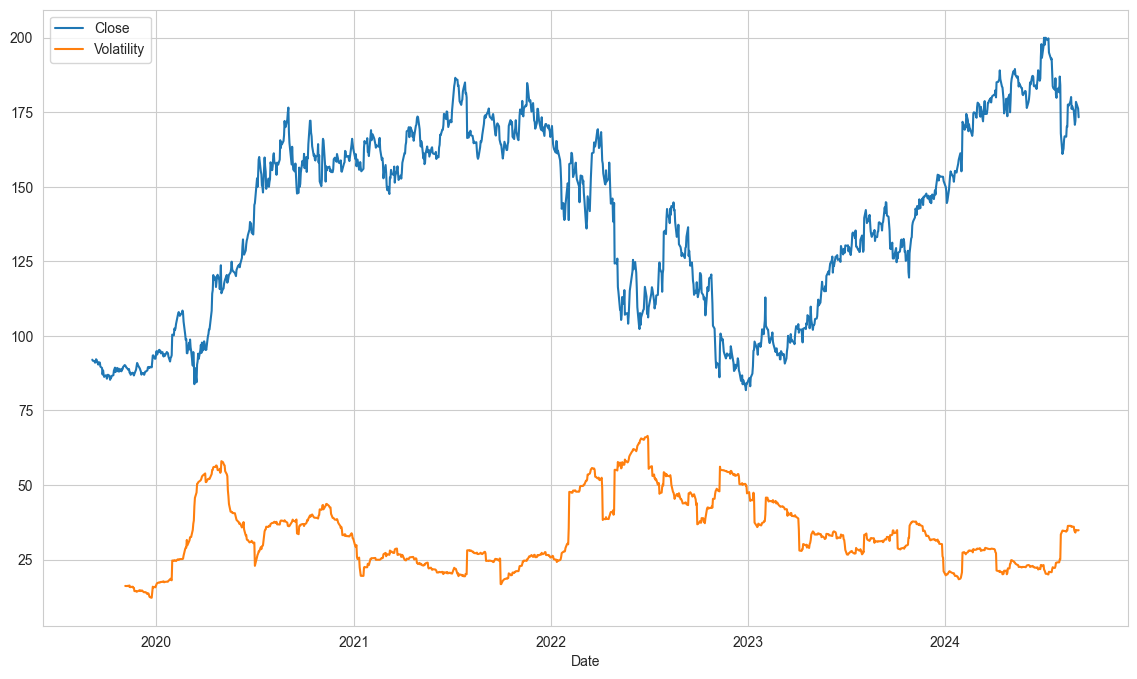

In [211]:
#Visualizing the volatility
plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( returns(t,252)*100, label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

#### Strike price

In [212]:
strike_price = 170
#sigma = 0.21842

Option price from yahoo finance

In [213]:
#expiry date for option price
expiry_date_new = "2024-10-18"


#### Calculating option value

In [222]:
BS(s,strike_price,last_yield,t,vol,'P')

np.float64(8.125735641823681)

In [223]:
black_scholes(s, strike_price, last_yield, t,vol,div_yield, 'Put')

{'option_type': 'Put',
 'premium': np.float64(8.1257),
 'Breakeven point': np.float64(161.8743),
 'detla': np.float64(-0.4024),
 'gamma': np.float64(0.015),
 'theta': np.float64(-0.1029),
 'vega': np.float64(0.277),
 'rho': np.float64(-0.1329)}

In [226]:
black_scholes(s, strike_price, last_yield, t, vol_std, div_yield, 'Put')

{'option_type': 'Put',
 'premium': np.float64(7.7758),
 'Breakeven point': np.float64(162.2242),
 'detla': np.float64(-0.401),
 'gamma': np.float64(0.0155),
 'theta': np.float64(-0.0987),
 'vega': np.float64(0.2768),
 'rho': np.float64(-0.1319)}

In [224]:
black_scholes_1(s, strike_price, t_years,div_yield, last_yield,vol, option='put')

np.float64(25.309293754563576)

#### Calculating probability of profit

POP = N[d2(S1)] - N[d2(S2)] 
where S1 < S2; N - cumulative distribution function assuming normal distribution

In [179]:
def d2_norm_cdf(s,k,sigma, r, t):
    T = t/252
    d2 = -(np.log(k/s) - (r - (sigma**2))*T) / (sigma * np.sqrt(T))
    return norm.cdf(d2)
    

In [180]:
s1 = 115
s2 = 125

In [181]:
#calculating probabiltiy of profit
pop = (d2_norm_cdf(s2,strike_price,sigma,r,t) - d2_norm_cdf(s1,strike_price,sigma,r,t))*100
print(" Probability of Profit is .{0:8.4f}%".format(pop) )

 Probability of Profit is .  0.0029%
